# 作業重點:

(1)以, Adam, 為例, 調整 batch_size, epoch , 觀察accurancy, loss 的變化

(2)以同一模型, 分別驗證 SGD, Adam, Rmsprop 的 accurancy

# 作業目標:
    
    取得各種優化器的運算結果

In [1]:
from __future__ import print_function
import keras
from keras.datasets import cifar10
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
import os
from keras import optimizers

import matplotlib.pyplot as plt
%matplotlib inline

Using TensorFlow backend.


In [2]:
#Blas GEMM launch failed , 避免動態分配GPU / CPU, 出現問題
import tensorflow as tf
gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=0.333)
sess = tf.Session(config=tf.ConfigProto(gpu_options=gpu_options))


In [3]:

'''
   宣告並設定
   batch_size：對總的樣本數進行分組，每組包含的樣本數量
   epochs ：訓練次數
   
''' 

#batch_size = 32
num_classes = 10
#epochs = 20
data_augmentation = True
num_predictions = 20
save_dir = os.path.join(os.getcwd(), 'saved_models')
model_name = 'keras_cifar10_trained_model.h5'


In [4]:

# The data, split between train and test sets:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

# Convert class vectors to binary class matrices.
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

x_train shape: (50000, 32, 32, 3)
50000 train samples
10000 test samples


In [5]:
def get_model():

    #    第一步：選擇模型, 順序模型是多個網絡層的線性堆疊

    model = Sequential()

    #   第二步：構建網絡層
    model.add(Conv2D(32, (3, 3), padding='same',
                     input_shape=x_train.shape[1:]))
    model.add(Activation('relu'))
    model.add(Conv2D(32, (3, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(64, (3, 3), padding='same'))
    model.add(Activation('relu'))
    model.add(Conv2D(64, (3, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Flatten())
    model.add(Dense(512))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))

    model.add(Dense( 10)) # 輸出結果是10個類別，所以維度是10   
    model.add(Activation('softmax')) # 最後一層用softmax作為激活函數
    
    return model

In [6]:
# 模型建立完成後，統計參數總量
model = get_model()
print("Total Parameters：%d" % model.count_params())

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Total Parameters：1250858


In [7]:
# 輸出模型摘要資訊
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
activation_1 (Activation)    (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 30, 30, 32)        9248      
_________________________________________________________________
activation_2 (Activation)    (None, 30, 30, 32)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 15, 15, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 15, 15, 64)        18496     
__________

In [8]:
# 資料正規化
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255


In [9]:
# 打包為function加速後續試驗

def experience(epochs, batch_size, opt):
    
    model = get_model()
    model.compile(optimizer = opt, loss = 'categorical_crossentropy', metrics = ['accuracy'])
    
    if not data_augmentation:
        print('Not using data augmentation.')
        history=model.fit(x_train, y_train,
                  batch_size=batch_size,
                  epochs=epochs,
                  validation_data=(x_test, y_test),
                  shuffle=True)
    
    else:
        print('Using real-time data augmentation.')
        print('')
        
    # This will do preprocessing and realtime data augmentation:
        datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        zca_epsilon=1e-06,  # epsilon for ZCA whitening
        rotation_range=0,  # randomly rotate images in the range (degrees, 0 to 180)
        # randomly shift images horizontally (fraction of total width)
        width_shift_range=0.1,
        # randomly shift images vertically (fraction of total height)
        height_shift_range=0.1,
        shear_range=0.,  # set range for random shear
        zoom_range=0.,  # set range for random zoom
        channel_shift_range=0.,  # set range for random channel shifts
        # set mode for filling points outside the input boundaries
        fill_mode='nearest',
        cval=0.,  # value used for fill_mode = "constant"
        horizontal_flip=True,  # randomly flip images
        vertical_flip=False,  # randomly flip images
        # set rescaling factor (applied before any other transformation)
        rescale=None,
        # set function that will be applied on each input
        preprocessing_function=None,
        # image data format, either "channels_first" or "channels_last"
        data_format=None,
        # fraction of images reserved for validation (strictly between 0 and 1)
        validation_split=0.0)

    # Compute quantities required for feature-wise normalization
    # (std, mean, and principal components if ZCA whitening is applied).
    datagen.fit(x_train)
    history=model.fit(x_train, y_train,
              batch_size=batch_size,
              epochs=epochs,
              validation_data=(x_test, y_test),
              shuffle=True)   
    
    print('')
    
    # Score trained model.
    print('Scoring trained model.')
    scores = model.evaluate(x_test, y_test, verbose=1)
    print('Test loss:', scores[0])
    print('Test accuracy:', scores[1])
    
    
    # Plot training & validation accuracy values
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Valiidation'], loc='upper left')
    plt.show()

    # Plot training & validation loss values
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Valiidation'], loc='upper left')
    plt.show()

## 以, Adam, 為例, 調整 batch_size, epoch , 觀察accurancy, loss 的變化

### batch_size=32, epoch=20(比照範例)
- Test loss: 0.6569020522117615
- Test accuracy: 0.7841

Using real-time data augmentation.

Instructions for updating:
Use tf.cast instead.
Train on 50000 samples, validate on 10000 samples
Epoch 1/20
50000/50000 [==============================] - 18s 370us/step - loss: 1.5354 - acc: 0.4351 - val_loss: 1.1999 - val_acc: 0.5687
Epoch 2/20
50000/50000 [==============================] - 16s 316us/step - loss: 1.1377 - acc: 0.5956 - val_loss: 0.9767 - val_acc: 0.6608
Epoch 3/20
50000/50000 [==============================] - 16s 318us/step - loss: 0.9794 - acc: 0.6531 - val_loss: 0.9575 - val_acc: 0.6598
Epoch 4/20
50000/50000 [==============================] - 16s 321us/step - loss: 0.8903 - acc: 0.6874 - val_loss: 0.8285 - val_acc: 0.7126
Epoch 5/20
50000/50000 [==============================] - 16s 318us/step - loss: 0.8232 - acc: 0.7125 - val_loss: 0.7960 - val_acc: 0.7214
Epoch 6/20
50000/50000 [==============================] - 16s 318us/step - loss: 0.7776 - acc: 0.7255 - val_loss: 0.7501 - val_acc: 0.7389
Epoch 7/20
50000/50000 [========

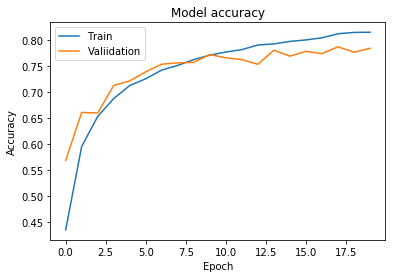

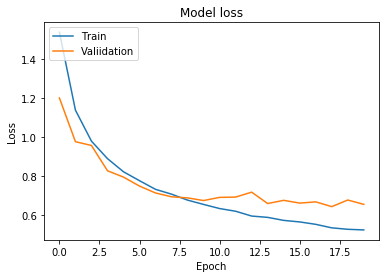

In [10]:
experience(epochs=20, batch_size=32, opt='adam')

### batch_size=32, epoch=40(增加訓練次數)
- Test loss: 0.6735034460783005
- Test accuracy: 0.7951
- 對比下增加epochs結果有比較好，但是改善速度很慢，差異也很小。

Using real-time data augmentation.

Train on 50000 samples, validate on 10000 samples
Epoch 1/40
50000/50000 [==============================] - 16s 329us/step - loss: 1.5191 - acc: 0.4478 - val_loss: 1.1369 - val_acc: 0.5936
Epoch 2/40
50000/50000 [==============================] - 16s 316us/step - loss: 1.1399 - acc: 0.5961 - val_loss: 0.9444 - val_acc: 0.6611
Epoch 3/40
50000/50000 [==============================] - 16s 317us/step - loss: 0.9946 - acc: 0.6501 - val_loss: 0.8563 - val_acc: 0.7018
Epoch 4/40
50000/50000 [==============================] - 16s 316us/step - loss: 0.9095 - acc: 0.6806 - val_loss: 0.8164 - val_acc: 0.7145
Epoch 5/40
50000/50000 [==============================] - 16s 316us/step - loss: 0.8373 - acc: 0.7061 - val_loss: 0.7907 - val_acc: 0.7251
Epoch 6/40
50000/50000 [==============================] - 16s 315us/step - loss: 0.7876 - acc: 0.7222 - val_loss: 0.7699 - val_acc: 0.7306
Epoch 7/40
50000/50000 [==============================] - 16s 315us/step - loss:

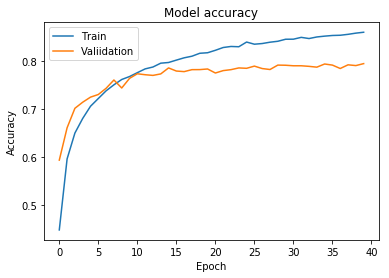

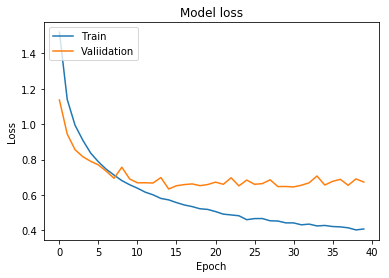

In [11]:
experience(epochs=40, batch_size=32, opt='adam')

### batch_size=512, epoch=20(加大batch_size)
- Test loss: 0.6301059487342835
- Test accuracy: 0.7815
- batch size加大後曲線變得更平滑，相較對照有一點underfit，但差異不大，而且訓練速度快很多，以這個case來說應該可以同時加大epoch和batch size來優化。

Using real-time data augmentation.

Train on 50000 samples, validate on 10000 samples
Epoch 1/20
50000/50000 [==============================] - 8s 155us/step - loss: 1.7767 - acc: 0.3453 - val_loss: 1.4191 - val_acc: 0.5000
Epoch 2/20
50000/50000 [==============================] - 6s 128us/step - loss: 1.3908 - acc: 0.4972 - val_loss: 1.2261 - val_acc: 0.5661
Epoch 3/20
50000/50000 [==============================] - 6s 128us/step - loss: 1.2395 - acc: 0.5574 - val_loss: 1.1174 - val_acc: 0.6043
Epoch 4/20
50000/50000 [==============================] - 6s 127us/step - loss: 1.1289 - acc: 0.5976 - val_loss: 1.0377 - val_acc: 0.6301
Epoch 5/20
50000/50000 [==============================] - 6s 128us/step - loss: 1.0379 - acc: 0.6330 - val_loss: 0.9367 - val_acc: 0.6684
Epoch 6/20
50000/50000 [==============================] - 6s 127us/step - loss: 0.9645 - acc: 0.6585 - val_loss: 0.8859 - val_acc: 0.6888
Epoch 7/20
50000/50000 [==============================] - 6s 127us/step - loss: 0.9007

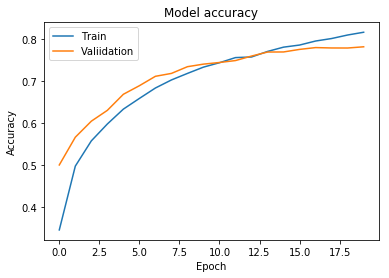

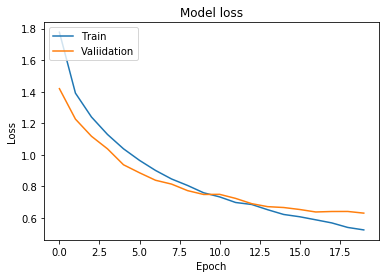

In [12]:
experience(epochs=20, batch_size=512, opt='adam')

### batch_size=8, epoch=20(縮小batch_size)
- Test loss: 0.8217168190002442
- Test accuracy: 0.7217
- Batch size縮得過小了，訓練過程不穩定，到最後的幾個epoch還有validation loss上升的情形。

Using real-time data augmentation.

Train on 50000 samples, validate on 10000 samples
Epoch 1/20
50000/50000 [==============================] - 59s 1ms/step - loss: 1.5659 - acc: 0.4230 - val_loss: 1.2628 - val_acc: 0.5527
Epoch 2/20
50000/50000 [==============================] - 56s 1ms/step - loss: 1.2394 - acc: 0.5569 - val_loss: 1.0785 - val_acc: 0.6183
Epoch 3/20
50000/50000 [==============================] - 57s 1ms/step - loss: 1.1312 - acc: 0.5973 - val_loss: 1.0350 - val_acc: 0.6363
Epoch 4/20
50000/50000 [==============================] - 55s 1ms/step - loss: 1.0707 - acc: 0.6230 - val_loss: 0.9433 - val_acc: 0.6703
Epoch 5/20
50000/50000 [==============================] - 55s 1ms/step - loss: 1.0307 - acc: 0.6359 - val_loss: 0.9388 - val_acc: 0.6670
Epoch 6/20
50000/50000 [==============================] - 55s 1ms/step - loss: 0.9927 - acc: 0.6522 - val_loss: 0.9754 - val_acc: 0.6605
Epoch 7/20
50000/50000 [==============================] - 55s 1ms/step - loss: 0.9675 - acc:

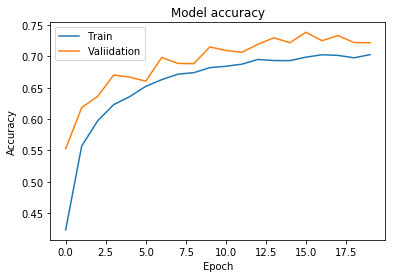

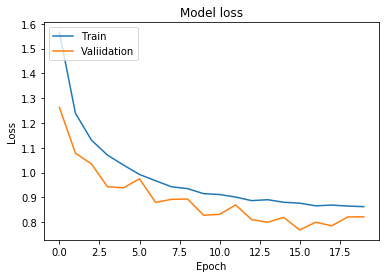

In [13]:
experience(epochs=20, batch_size=8, opt='adam')

## 以同一模型, 分別驗證 SGD, Adam, Rmsprop 的 accurancy

### 使用SGD
- Test loss: 0.7416549469947815
- Test accuracy: 0.7448
- 訓練速度比adam快一點，但每個epoch的改善幅度也比較小。

Using real-time data augmentation.

Train on 50000 samples, validate on 10000 samples
Epoch 1/20
50000/50000 [==============================] - 15s 290us/step - loss: 2.1024 - acc: 0.2185 - val_loss: 1.8782 - val_acc: 0.3329
Epoch 2/20
50000/50000 [==============================] - 14s 275us/step - loss: 1.8205 - acc: 0.3404 - val_loss: 1.6621 - val_acc: 0.4044
Epoch 3/20
50000/50000 [==============================] - 14s 272us/step - loss: 1.6394 - acc: 0.4035 - val_loss: 1.5164 - val_acc: 0.4524
Epoch 4/20
50000/50000 [==============================] - 14s 278us/step - loss: 1.5180 - acc: 0.4468 - val_loss: 1.3882 - val_acc: 0.5149
Epoch 5/20
50000/50000 [==============================] - 14s 278us/step - loss: 1.4204 - acc: 0.4859 - val_loss: 1.3011 - val_acc: 0.5337
Epoch 6/20
50000/50000 [==============================] - 14s 278us/step - loss: 1.3408 - acc: 0.5186 - val_loss: 1.2779 - val_acc: 0.5410
Epoch 7/20
50000/50000 [==============================] - 14s 279us/step - loss:

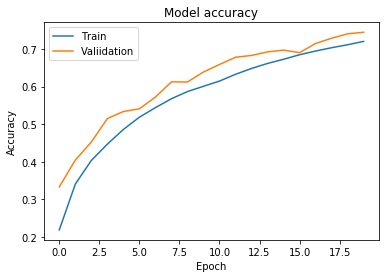

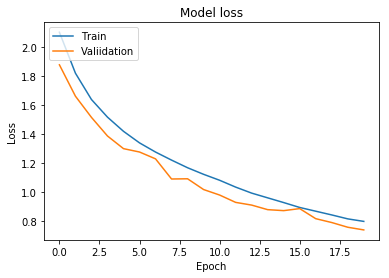

In [14]:
experience(epochs=20, batch_size=32, opt='SGD')

### 使用adam
- Test loss: 0.6357559587478637
- Test accuracy: 0.7876

Using real-time data augmentation.

Train on 50000 samples, validate on 10000 samples
Epoch 1/20
50000/50000 [==============================] - 17s 339us/step - loss: 1.5461 - acc: 0.4342 - val_loss: 1.2463 - val_acc: 0.5558
Epoch 2/20
50000/50000 [==============================] - 16s 317us/step - loss: 1.1382 - acc: 0.5975 - val_loss: 0.9625 - val_acc: 0.6626
Epoch 3/20
50000/50000 [==============================] - 16s 318us/step - loss: 0.9715 - acc: 0.6579 - val_loss: 0.8396 - val_acc: 0.7089
Epoch 4/20
50000/50000 [==============================] - 16s 318us/step - loss: 0.8811 - acc: 0.6917 - val_loss: 0.8202 - val_acc: 0.7088
Epoch 5/20
50000/50000 [==============================] - 16s 319us/step - loss: 0.8209 - acc: 0.7129 - val_loss: 0.7717 - val_acc: 0.7294
Epoch 6/20
50000/50000 [==============================] - 16s 316us/step - loss: 0.7725 - acc: 0.7284 - val_loss: 0.8081 - val_acc: 0.7248
Epoch 7/20
50000/50000 [==============================] - 16s 314us/step - loss:

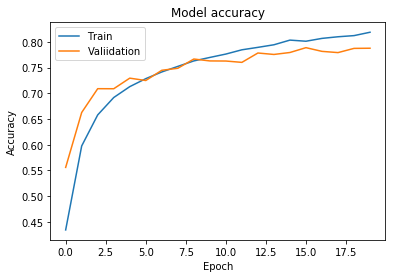

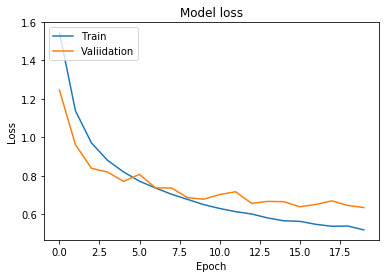

In [15]:
experience(epochs=20, batch_size=32, opt='adam')

### 使用Rmsprop
- Test loss: 1.521321802330017
- Test accuracy: 0.4572
- 比adam略快一點點。
- 學習效果很不穩定，後半的結果反而變差了？

Using real-time data augmentation.

Train on 50000 samples, validate on 10000 samples
Epoch 1/20
50000/50000 [==============================] - 16s 330us/step - loss: 1.5219 - acc: 0.4519 - val_loss: 1.2352 - val_acc: 0.5622
Epoch 2/20
50000/50000 [==============================] - 15s 306us/step - loss: 1.1208 - acc: 0.6105 - val_loss: 0.9745 - val_acc: 0.6619
Epoch 3/20
50000/50000 [==============================] - 15s 307us/step - loss: 1.0090 - acc: 0.6534 - val_loss: 0.9669 - val_acc: 0.6753
Epoch 4/20
50000/50000 [==============================] - 15s 308us/step - loss: 0.9657 - acc: 0.6721 - val_loss: 0.8195 - val_acc: 0.7223
Epoch 5/20
50000/50000 [==============================] - 15s 307us/step - loss: 0.9714 - acc: 0.6775 - val_loss: 0.9242 - val_acc: 0.6934
Epoch 6/20
50000/50000 [==============================] - 15s 307us/step - loss: 0.9835 - acc: 0.6745 - val_loss: 0.8479 - val_acc: 0.7208
Epoch 7/20
50000/50000 [==============================] - 15s 308us/step - loss:

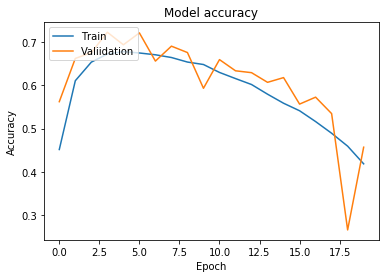

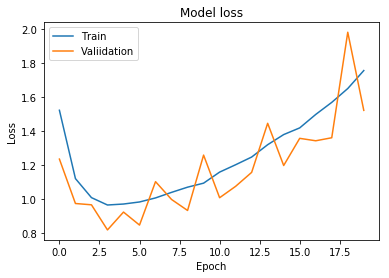

In [16]:
experience(epochs=20, batch_size=32, opt='Rmsprop')